# Leading NPM Libraries

###  Draft RPGF3 List ✨

In [1]:
from collections import defaultdict
from datetime import datetime, timedelta, timezone
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "LeadingNPMLibraries"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-02_LeadingLibraries.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list only considers projects with libraries published to npm and at least 100 weekly",
                "downloads. The list identifies the peak weekly downloads for a project's most popular package",
                "and awards OP Tokens in proportion to the square root of max weekly downloads. In other words,",
                "it favors more popular libraries but is also fairly egalitarian."
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            #'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

AWARD_AMT = 1 * 10e6

JSON_PATH = DATA_DIR + "lists/" + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
#duplicates = oso.check_duplicate_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
min_downloads = 100
type_id = 9 # downloads

query = f"""
    SELECT
        p.slug,
        max(e.amount)
    FROM
        event e
    LEFT JOIN
        project_artifacts_artifact paa ON e."toId" = paa."artifactId"
    LEFT JOIN
        project p ON paa."projectId" = p."id"
    WHERE
        p.slug IN ('{slugs_list}')
        AND e."typeId" = {type_id}
        AND e.amount >= {min_downloads}
    GROUP BY
        p.slug;

"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

popular_packages = {project: downloads**.5 for (project,downloads) in results}

# Generate the list

In [6]:
named_list = listify(popular_packages, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

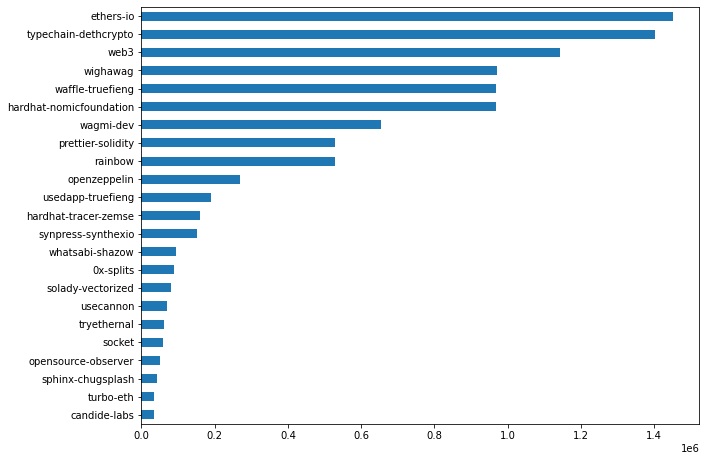

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)